# Credit Card Fraud Detection with Machine Learning Models
## Model Training
### Ian Heung

In the previous notebook, we made 5 different training datasets that feature various sampling methods to mitigate the effects of the class imbalance in the original dataset. We will now train the training data on various models and evaluate which sampling method will create a model that yields the best results on our testing data.

## Model Choices

We will choose 4 model types: 

- Decision Trees
- KNNs (K-Nearest Neighbors)
- Logistic Regression
- Support Vector Machines

Below are some of the Pros and Cons for each model type:

| Model | Pros | Cons |
|-|-|-|
| **Decision Trees** | - Handles non-linearity <br> - Provides insight into feature importance | - Prone to overfitting <br> - Bias towards features with more levels <br> - Instability with small changes in data |
| **K-Nearest Neighbors (KNN)** | - Simple methodology <br>  - Flexible with distance metrics | - Computationally intensive <br> - Sensitive to noise <br> - Not as good with higher dimensionalities|
| **Logistic Regression** | - Ideal for binary classification <br>  - Regularization available | - Assumes linear decision boundary <br> - Not ideal for large feature sets |
| **Support Vector Machines (SVM)** | - Effective in high-dimensional spaces <br> - Versatile kernels for non-linearity <br> - Robust to overfitting | - Computationally expensive <br> - Hyperparameter selection and tuning can be challenging|

In addition to each of the model types, a grid search for hyperparamter tuning will be performed each fitting where possible. Since we are testing all the differently sampled datasets on each model type, we need to be aware of the dataset size, since there are some models that will be less effective due to computational costs.

## Model Training

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix 

import warnings
warnings.filterwarnings("ignore")

### False Positives vs False Negatives

If we think back to the problem we are trying to solve, we need to focus on the recall of our model at identifying fraudulent transactions. We want to minimize the amount of actual fraudulent transactions that do not get classified correctly, even at the cost of misclassifying non-fraudulent transactions as fraudulent. This means we want to prioritize minimizing **false negatives**. Below is a confusion matrix that is an example case that shows a sample model that predicts whether transactions are fraudulent. 

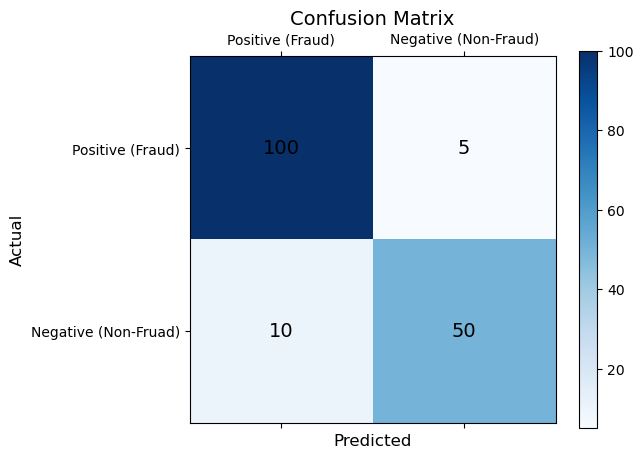

In [51]:
example_matrix = np.array([[100, 5],  # True Positives, False Negative
                             [10, 50]])  # False Positive, True Negative

fig, ax = plt.subplots()

cax = ax.matshow(example_matrix, cmap='Blues')

plt.colorbar(cax)

for (i, j), value in np.ndenumerate(example_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Positive (Fraud)', 'Negative (Non-Fraud)'])
ax.set_yticklabels(['Positive (Fraud)', 'Negative (Non-Fruad)'])

plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()

plt.show()

The model is good at detecting true positives (fraudulent cases). It might seem counterintuitive that fraudulent cases are considered positive, but because this is the class we particularly care about, it is labeled as the positive class. However, we see that there are 5 fraud cases incorrectly classified as non-fraud by the model, these are the **false negatives**. This is concerning because it means the model failed to detect these fraudulent cases. Additionally, we observe that the model has classified 10 non-fraud cases as fraud, these are the **false positives**. This outcome is preferable, as we would rather be more cautious and flag potential fraud cases, even if there is no actual fraud. In this situation, we prefer to have more false positives, which are non-fraud cases classified as fraud, while minimizing false negatives, which are fraud cases are classified as non-fraud.

### Load Data

Lets load in our training data for all 5 sampling cases. If we recall, these were the sampling cases each number corresponded to:

1. No Balancing at All
2. Undersampling
3. Oversampling
4. Mixed Sampling (Undersampling + Oversampling)
5. Mixed Sampling + Outlier Removal

Since we have 5 sets of data of different sizes for sampling case 4 and 5, we will store each dataset in a list corresponding to the sampling method. We will use a for loop to iterate through the list during model training.

In [3]:
# data directory
directory = 'data'

# 1 - unsampled data
xtrain_1 = pd.read_csv(os.path.join(directory, 'xtrain.csv'))
ytrain_1 = pd.read_csv(os.path.join(directory, 'ytrain.csv'))

# convert to numpy arrays
xtrain_1 = xtrain_1.values
ytrain_1 = ytrain_1.values

# 2 - undersampled data
xtrain_2 = pd.read_csv(os.path.join(directory, 'xtrain_undersampled.csv'))
ytrain_2 = pd.read_csv(os.path.join(directory, 'ytrain_undersampled.csv'))

xtrain_2 = xtrain_2.values
ytrain_2 = ytrain_2.values

# 3 - oversampled data
xtrain_3 = pd.read_csv(os.path.join(directory, 'xtrain_oversampled.csv'))
ytrain_3 = pd.read_csv(os.path.join(directory, 'ytrain_oversampled.csv'))

xtrain_3 = xtrain_3.values
ytrain_3 = ytrain_3.values

# 4 - mix sampled data
mix_sample_sizes = np.load(os.path.join(directory, 'mix_sample_sizes.npy')) # for parsing filenames of case 4 and 5
xtrain_4 = []
ytrain_4 = []

# iterate mix_sample_sizes that were saved 
for n in mix_sample_sizes:
    x = pd.read_csv(os.path.join(directory, f'xtrain_mix_{n}.csv'))
    y = pd.read_csv(os.path.join(directory, f'ytrain_mix_{n}.csv'))
    
    x = x.values
    y = y.values
    
    xtrain_4.append(x)
    ytrain_4.append(y)

# 5 - filtered mix sampled data
xtrain_5 = []
ytrain_5 = []

for n in mix_sample_sizes:
    x = pd.read_csv(os.path.join(directory, f'xtrain_mix_{n}.csv'))
    y = pd.read_csv(os.path.join(directory, f'ytrain_mix_{n}.csv'))
    
    x = x.values
    y = y.values
    
    xtrain_5.append(x)
    ytrain_5.append(y)
    
# test data
xtest = pd.read_csv(os.path.join(directory, 'xtest.csv'))
ytest = pd.read_csv(os.path.join(directory, 'ytest.csv'))

xtest = xtest.values
ytest = ytest.values

### Model Training
We will define our model training pipeline here. The range of the grid search terms has been determined through multiple training tests.

When running computationally intensive models like KNN and SVM, it would take hours for the model to train and sometimes cause my local device to crash. Therefore, the model training pipeline is configured in a way where it will not train the KNN and SVM models if the input data size exceeds 50,000 datapoints. The grid search is also not as comprehensive as it could be, but I have selected a sensible range of hyperparameters to tune.

For the scoring metric, our main goal is to maximize recall for the positive class (fraudulent transactions) while also ensuring the model does not default to predicting only the positive class for all transactions. To achieve this, I created a custom metric that combines the recall for the positive class with the macro F1 score. This composite score helps ensure that we don’t overfit purely on recall while also maintaining a balanced model across both classes.

In [4]:
# custom scoring function
def composite_scorer(y_true, y_pred):
    rec_pos_class = recall_score(y_true, y_pred, pos_label=1) # positive class recall
    f1_macro = f1_score(y_true, y_pred, average='macro') # macro f1 score
    
    # combine the two scores and divide by 2
    comp_score = (rec_pos_class + f1_macro) / 2

    return comp_score

In [5]:
# model training pipeline
def train_models(xtrain, ytrain):
    
    # intialize our model types
    decision_trees = DecisionTreeClassifier()
    knn = KNeighborsClassifier()
    logistic = LogisticRegression()
    svm = SVC()

    # decision trees grid search hyperparameters
    dt_hyperparams = {
            "max_depth": [10, 20, 30],
            "criterion": ["gini", "entropy"],
            "max_leaf_nodes": [10, 20, 30]
        }

    # knn grid search hyperparameters
    knn_hyperparams = {
        'n_neighbors': [2, 5, 10, 15],
        'weights': ['uniform', 'distance']
        }

    # logistic regression hyperparameters
    logistic_hyperparams = {
        "penalty": ['l1', 'l2'], 
        'C': [0.01, 0.1, 1, 10]
        }

    # support vector machines hyperparameters
    svm_hyperparams = {
        'C': [0.1, 1, 10], 
        'kernel': ['rbf', 'poly', 'linear']
        }

    # custom scorer
    composite_score = make_scorer(composite_scorer)
    
    # put into a triplet for parsing into for loop
    models = [('Decision Trees', decision_trees, dt_hyperparams), 
            ('KNN', knn, knn_hyperparams), 
            ('Logistic Regression', logistic, logistic_hyperparams),
            ('Support Vector Machines', svm, svm_hyperparams)]
    
    # save results to a dictionary
    results = {}
    
    # iterate list of triplets
    for name, model, grid in models:
        # change cross validation fold based on dataset size
        if len(xtrain) >= 50000:
            cv_folds = 3
        else:
            cv_folds = 5
            
        # skip training for KNN and SVM on very large datasets
        if (len(xtrain)) < 50000 or (name != 'KNN' and name != 'Support Vector Machines'):
            clf = GridSearchCV(
                estimator=model, 
                param_grid=grid,
                scoring=composite_score, 
                cv=cv_folds,  
                verbose=3, 
                n_jobs=-1
            )

            print("Training", name, "Model")
            
            # fit training data                    
            classifier = clf.fit(xtrain, ytrain)
            
            print("Validation fitting with best custom score:", clf.best_score_)
            print("Best parameters found from grid search: ", clf.best_params_)
            print()

            results[name] = [classifier.best_estimator_, clf.best_score_, clf.best_params_]
        else:
            results[name] = 'Skipped'
            print(name, 'Model skipped due to long training time')
            print()
            
    return results

#### 1 - No Sampling

The dataset is too large, so we don't train KNN and SVM models.

In [6]:
results_1 = train_models(xtrain_1, ytrain_1)

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best custom score: 0.8374964956876765
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 10}

KNN Model skipped due to long training time

Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best custom score: 0.7565832811762699
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time



#### 2 - Undersampling

In [7]:
results_2 = train_models(xtrain_2, ytrain_2)

Training Decision Trees Model
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Validation fitting with best custom score: 0.9052884654601948
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 30}

Training KNN Model
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Validation fitting with best custom score: 0.92695205059139
Best parameters found from grid search:  {'n_neighbors': 2, 'weights': 'distance'}

Training Logistic Regression Model
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Validation fitting with best custom score: 0.924304176187017
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}

Training Support Vector Machines Model
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Validation fitting with best custom score: 0.9211829591267605
Best parameters found from grid search:  {'C': 10, 'kernel': 'linear'}



#### 3 - Oversampling

The dataset is too large, so we don't train KNN and SVM models.

In [8]:
results_3 = train_models(xtrain_3, ytrain_3)

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best custom score: 0.9648722081775909
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time

Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best custom score: 0.9308753940855788
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time



#### 4 - Mixed Sampling

The dataset size vaires. It is too large for the first two mixed sampling sets, so we don't train KNN and SVM models on them. We do train KNN and SVM models on the remaining 3.

In [9]:
# 0 - 227450
results_4_0 = train_models(xtrain_4[0], ytrain_4[0]) # No KNN, SVM
# 1 - 71926
results_4_1 = train_models(xtrain_4[1], ytrain_4[1]) # No KNN, SVM
# 2 - 22744
results_4_2 = train_models(xtrain_4[2], ytrain_4[2])
# 3 - 7192
results_4_3 = train_models(xtrain_4[3], ytrain_4[3])
# 4 - 2274
results_4_4 = train_models(xtrain_4[4], ytrain_4[4])

results_4 = [results_4_0, results_4_1, results_4_2, results_4_3, results_4_4]

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best custom score: 0.9653929871277565
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time

Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best custom score: 0.9312176218912898
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best custom score: 0.9652958659968148
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time

Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Valida

#### 5 - Mixed Sampling + Outlier Removal

Same as 4 - Mixed Sampling, the dataset size vaires. The same training methods are applied.

In [10]:
# 0 - 227450
results_5_0 = train_models(xtrain_5[0], ytrain_5[0]) # No KNN, SVM
# 1 - 71926
results_5_1 = train_models(xtrain_5[1], ytrain_5[1]) # No KNN, SVM
# 2 - 22744
results_5_2 = train_models(xtrain_5[2], ytrain_5[2])
# 3 - 7192
results_5_3 = train_models(xtrain_5[3], ytrain_5[3])
# 4 - 2274
results_5_4 = train_models(xtrain_5[4], ytrain_5[4])

results_5 = [results_5_0, results_5_1, results_5_2, results_5_3, results_5_4]

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best custom score: 0.9653929871277565
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time

Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Validation fitting with best custom score: 0.9312176218912898
Best parameters found from grid search:  {'C': 10, 'penalty': 'l2'}

Support Vector Machines Model skipped due to long training time

Training Decision Trees Model
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Validation fitting with best custom score: 0.9652958659968148
Best parameters found from grid search:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

KNN Model skipped due to long training time

Training Logistic Regression Model
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Valida

### Grid Search Cross Validation Results

The models are now all trained. Lets see the validation results of all the sampling and model types by looking at the performance on validation data, as well as the hyperparemeters selected from the grid search.

In [11]:
# we define a function for easy viewing of our validation results
def print_results(results):
    # reference each model the dictonary keys 
    for k in results.keys():
        # If a model is skipped, this is the print output
        if results[k] == 'Skipped':
            print("Model: ", k)
            print(results[k])
            print()
        else:
            print("Model: ", k)
            print("Best Score: ", results[k][1])
            print("Best Parameters: ", results[k][2])
            print()

#### 1 - No Sampling

In [12]:
print_results(results_1)

Model:  Decision Trees
Best Score:  0.8374964956876765
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 10}

Model:  KNN
Skipped

Model:  Logistic Regression
Best Score:  0.7565832811762699
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped



#### 2 - Undersampling

In [13]:
print_results(results_2)

Model:  Decision Trees
Best Score:  0.9052884654601948
Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 30}

Model:  KNN
Best Score:  0.92695205059139
Best Parameters:  {'n_neighbors': 2, 'weights': 'distance'}

Model:  Logistic Regression
Best Score:  0.924304176187017
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Best Score:  0.9211829591267605
Best Parameters:  {'C': 10, 'kernel': 'linear'}



#### 3 - Oversampling

In [14]:
print_results(results_3)

Model:  Decision Trees
Best Score:  0.9648722081775909
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped

Model:  Logistic Regression
Best Score:  0.9308753940855788
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped



#### 4 - Mixed Sampling
There is a scrollable output since the output gets truncated.

In [15]:
# for loop to iterate through the different mixed sampling models
for i in range(len(results_4)):
    print("Number of Datapoints", mix_sample_sizes[i])
    print_results(results_4[i])
    print()

Number of Datapoints 227450
Model:  Decision Trees
Best Score:  0.9653929871277565
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped

Model:  Logistic Regression
Best Score:  0.9312176218912898
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped


Number of Datapoints 71926
Model:  Decision Trees
Best Score:  0.9652958659968148
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped

Model:  Logistic Regression
Best Score:  0.9306701942247354
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped


Number of Datapoints 22744
Model:  Decision Trees
Best Score:  0.9611757712226515
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Best Score:  0.9974278975522702
Best Parameters:  {'n_neighbors': 2, 'weights': 'uniform'}

Model:  Logistic Regression
Best Score:  0.932160094683146
Bes

#### 5 - Mixed Sampling + Outlier Removal
There is a scrollable output since the output gets truncated.

In [16]:
# for loop to iterate through the different mixed sampling models
for i in range(len(results_5)):
    print("Number of Datapoints", mix_sample_sizes[i])
    print_results(results_5[i])
    print()

Number of Datapoints 227450
Model:  Decision Trees
Best Score:  0.9653929871277565
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped

Model:  Logistic Regression
Best Score:  0.9312176218912898
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped


Number of Datapoints 71926
Model:  Decision Trees
Best Score:  0.9652958659968148
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Skipped

Model:  Logistic Regression
Best Score:  0.9306701942247354
Best Parameters:  {'C': 10, 'penalty': 'l2'}

Model:  Support Vector Machines
Skipped


Number of Datapoints 22744
Model:  Decision Trees
Best Score:  0.9611757712226515
Best Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30}

Model:  KNN
Best Score:  0.9974278975522702
Best Parameters:  {'n_neighbors': 2, 'weights': 'uniform'}

Model:  Logistic Regression
Best Score:  0.932160094683146
Bes

From our intial preview of the models, even the base case no sampling models performed decently despite the data imbalance, with 70-80% on our custom weighted score. But we also see some models that have scores that seem too high, close to 98-99%, which is an indication of overfitting. Most of the results hover around 92-96%. Because of the size of some datasets, we were not able to train KNN and SVM models on those datasets. This was one of the tradeoffs we had to make when using these two models due to their high computational costs.

### Model Evaluation

Now that we have trained our models, it is time to evaluate them on our testing data. We will evaluate all the models and generate predictions on the test data. We create a function to parse in our model training results and filter out the models that were skipped due to computational limitations. 

In [17]:
# function to evaluate and make predictions on test data
def evaluate_results(results, xtest):
    ypred_array = []
    for k in results.keys():
        if results[k] == 'Skipped':
            ypred_array.append([])
        else:
            model = results[k][0]
            ypred = model.predict(xtest)
            ypred_array.append(ypred)
    return ypred_array

In [18]:
ypreds_1 = evaluate_results(results_1, xtest)
ypreds_2 = evaluate_results(results_2, xtest)
ypreds_3 = evaluate_results(results_3, xtest)

# append the predictions for each mixed sampled dataset into a list
ypreds_4 = []
for i in range(len(results_4)):
     ypreds_4.append(evaluate_results(results_4[i], xtest))
     
ypreds_5 = []
for i in range(len(results_5)):
     ypreds_5.append(evaluate_results(results_5[i], xtest))


The easiest way to visualize how our model is doing is to use a confusion matrix. Because we skipped training KNN and SVM models for large datasets, we need to add an option to display 2 models instead of 4 for each sampling set. The following custom function will produce a confusion matrix plot and save it to a plots folder. Both standard and row normalized confusion matrices will be created. I chose to normalize by row because it represents the class recall. We are not as concerend about precision in this scenario, as we want to prioritze the recall of the positive class.

In [19]:
def plot_confusion_matrix(ypreds, title, filename, num_plots, normalize, show_plot):
    if num_plots == 2:
        ypreds = ypreds[0:3:2]
        model_types = ["Decision Trees", "Logistic Regression"]
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 2x1 grid of subplots

        # iterate each subplot
        for m, ax in enumerate(axes.ravel()):
            cm = confusion_matrix(ytest, ypreds[m], normalize='true' if normalize else None)
            cm = cm[[1, 0], :]  # reorder the confusion matrix to flip rows
            cm = cm[:, [1, 0]]  # reorder the confusion matrix to flip columns

            cax = ax.matshow(cm, cmap='Blues')

            # annotate cells with the number of instances or percentages
            for (i, j), value in np.ndenumerate(cm):
                if normalize:
                    ax.text(j, i, f'{value:.4f}', ha='center', va='center', color='black', fontsize=15)
                else:
                    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=15)

            ax.set_xlabel('Predicted', fontsize=12)
            ax.set_ylabel('Actual', fontsize=12)

            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels(['Fraud', 'Non-Fraud'])  # flipped order
            ax.set_yticklabels(['Fraud', 'Non-Fraud'])  # flipped order

            ax.set_title(f'{model_types[m]} Confusion Matrix')

    elif num_plots == 4:        
        model_types = ["Decision Trees", "KNN", "Logistic Regression", "SVM"]
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid of subplots

        for m, ax in enumerate(axes.ravel()):
            cm = confusion_matrix(ytest, ypreds[m], normalize='true' if normalize else None)
            cm = cm[[1, 0], :]  # reorder the confusion matrix to flip rows
            cm = cm[:, [1, 0]]  # reorder the confusion matrix to flip columns

            cax = ax.matshow(cm, cmap='Blues')

            # annotate cells with the number of instances or percentages
            for (i, j), value in np.ndenumerate(cm):
                if normalize:
                    ax.text(j, i, f'{value:.4f}', ha='center', va='center', color='black', fontsize=15)
                else:
                    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=15)

            ax.set_xlabel('Predicted', fontsize=12)
            ax.set_ylabel('Actual', fontsize=12)

            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels(['Fraud', 'Non-Fraud'])  # flipped order
            ax.set_yticklabels(['Fraud', 'Non-Fraud'])  # flipped order

            ax.set_title(f'{model_types[m]} Confusion Matrix')
            
    else:
        print("Invalid number of plots")
        return
        
    fig.suptitle(title, fontsize = 16)
    plt.tight_layout()
    
    # save plot
    directory = 'plots'
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plt.savefig(os.path.join(directory, f'{filename}.png'))
    
    # option to show plot in output
    if show_plot:
        plt.show()
    else:
        plt.close(fig)


In [20]:
plot_confusion_matrix(ypreds_1, '1 - No Sampling' , '1_no_sampling', 2, normalize=False, show_plot=False)
plot_confusion_matrix(ypreds_1, '1 - No Sampling (Normalized)' , '1_no_sampling_norm', 2, normalize=True, show_plot=False)

In [21]:
plot_confusion_matrix(ypreds_2, '2 - Undersampling', '2_undersampling', 4, normalize=False, show_plot=False)
plot_confusion_matrix(ypreds_2, '2 - Undersampling (Normalized)' , '2_undersampling_norm', 4, normalize=True, show_plot=False)

In [22]:
plot_confusion_matrix(ypreds_3, '3 - Oversampling', '3_oversampling', 2, normalize=False, show_plot=False)
plot_confusion_matrix(ypreds_3, '3 - Oversampling (Normalized)', '3_oversampling_norm', 2, normalize=True, show_plot=False)


There are more plots for *4 - mixed sampling* and *5 - mixed sampling with outliers removed* since they have 5 sampling sets for each sampling case. We use for loops to plot multiple confusion matrices.

In [23]:
# iterate through ypreds_4 and assign filename based on num data points
for i in range(len(ypreds_4)): 
    # our num_plots changes if the sampling set did not train KNN and SVM models
    if len(ytrain_4[i]) >= 50000:
        num_plots = 2
    else:
        num_plots = 4
    
    # do not show plots as will fill up whole screen
    plot_confusion_matrix(ypreds_4[i], f'4 - Mixed Sampling ({mix_sample_sizes[i]} Training Points)', f'4_mix_sampling_{mix_sample_sizes[i]}', num_plots, normalize=False, show_plot=False) 
    plot_confusion_matrix(ypreds_4[i], f'4 - Mixed Sampling (Normalized, {mix_sample_sizes[i]} Training Points)', f'4_mix_sampling_norm_{mix_sample_sizes[i]}', num_plots, normalize=True, show_plot=False) 

In [24]:
# iterate through ypreds_5 and assign filename based on num data points
for i in range(len(ypreds_5)): 
    # our num_plots changes if the sampling set did not train KNN and SVM models
    if len(ytrain_5[i]) >= 50000:
        num_plots = 2
    else:
        num_plots = 4
    
    # do not show plots as will fill up whole screen
    plot_confusion_matrix(ypreds_5[i], f'5 - Mixed Sampling + Outliers Removed ({mix_sample_sizes[i]} Training Points)', f'5_filtered_sampling_{mix_sample_sizes[i]}', num_plots, normalize=False, show_plot=False)
    plot_confusion_matrix(ypreds_5[i], f'5 - Mixed Sampling + Outliers Removed (Normalized, {mix_sample_sizes[i]} Training Points)', f'5_filtered_sampling_norm_{mix_sample_sizes[i]}', num_plots, normalize=True, show_plot=False) 

### Confusion Matrices

Using confusion matrices is one of the best ways to see how our models are classifying data on a class specific basis. In our situation, we have many confusion matrices for each sampling dataset, and also the option to show standard or normalized values. As such, only relevant confusion matrices will be shown to avoid overloading the notebook with too many plots. All the confusion matrices can be seen in the `plots` folder.

#### 1 - No Sampling and 3 - Oversampling

<table>
  <tr>
    <th>1 - No Sampling</th>
    <th>1 - No Sampling (Normalized)</th>
  </tr>
  <tr>
    <td><img src="plots/1_no_sampling.png?v=3" alt="1" width="600"/></td>
    <td><img src="plots/1_no_sampling_norm.png?v=3" alt="1_norm" width="600"/></td>
  </tr>
  <tr>
    <th>3 - Oversampling</th>
    <th>3 - Oversampling (Normalized)</th>
  </tr>
  <tr>
    <td><img src="plots/3_oversampling.png?v=3" alt="3" width="600"/></td>
    <td><img src="plots/3_oversampling_norm.png?v=3" alt="3_norm" width="600"/></td>
  </tr>
</table>

KNN and SVM models were not able to be trained for the following two sampling cases due to computational limits.

As expected, the models that trained without using any sampling have overfitting because of the class imbalance. Even though it is the base case, we see that the model is very good at detecting non-fraudulent cases. It has the highest recall for detecting non-fraudulent transactions. However, because of the overfitting, it is not as sensitive to fraudulent transactions, with the decision trees model only correctly classifying **76.55%** of fraud transactions and the logistic regression model correctly classifying **58.16%** of fraud transactions.

When we oversampled the data, we saw a large improvement in the results for the decision trees and logistic regression models. The decision trees model correctly classified **87.76%** of fraudulent transactions, while the logistic regression model correctly classified **91.84%** of fraudulent transactions. However, because we used SMOTE, the training data is not a direct reflection of the true data, so the models are likely good at generalizing but cannot correctly identify edge cases due to the usage of artificial data during training.

#### 2 - Undersampling

  <table>
  <tr>
    <th>2 - Undersampling</th>
    <th>2 - Undersampling (Normalized)</th>
  </tr>
  <tr>
    <td><img src="plots/2_undersampling.png?v=3" alt="2" width="600"/></td>
    <td><img src="plots/2_undersampling_norm.png?v=3" alt="2_norm" width="600"/></td>
  </tr>
</table>


When we undersampled the training data, compared to when we oversampled the training data, we observed an improvement in the recall score of the positive class. Since there was less data, we were able to train the KNN and SVM models. Both the KNN and SVM models show good recall scores for the positive class, with the SVM model reaching **93.88%**. However, the best model of the four is the logistic regression model. While it has the same recall score as the SVM model for the positive class, it performs better in classifying the negative class (non-fraud transactions), giving the logistic regression model a slight edge.

#### 4 - Mixed Sampling

<table>
  <tr>
    <th>4 - Mixed Sampling (7192 Data Points)</th>
    <th>4 - Mixed Sampling (Normalized, 7192 Data Points)</th>
  </tr>
  <tr>
    <td><img src="plots/4_mix_sampling_7192.png?v=3" alt="4_7192" width="600"/></td>
    <td><img src="plots/4_mix_sampling_norm_7192.png?v=3" alt="4_norm_7192" width="600"/></td>
  </tr>
</table>

A total of 20 models were developed from the 5 differently sampled training datasets, containing: 227450, 71926, 22744, 7192, and 2274 training datapoints (50%, 15.81%, 5%, 1.581%, 0.5%, of oversampled training dataset). To recap, the positive class was oversampled, and the negative class was undersampled in order to reach a 50-50 class balance. The objective of this method was to find a middle ground where we could maximize the benefits of both undersampling and oversampling to develop the most robust training dataset.

I have picked out the best peforming training set, the 1.581% (7192 datapoints) training set. The model with the highest recall on the positive class was the logistic regression model with a recall of **93.88%**, only incorrectly classifying 6 fraudulent transactions. It has the same recall score on the positive class as the undersampled logistic regression model, but has a better overall recall score since its recall score on the negative class is higher.

#### 5 - Mixed Sampling + Outliers Removed

<table>
  <tr>
    <th>5 - Mixed Sampling, Outliers Removed (7192 Data Points)</th>
    <th>5 - Mixed Sampling, Outliers Removed(Normalized, 7192 Data Points)</th>
  </tr>
  <tr>
    <td><img src="plots/5_filtered_sampling_7192.png?v=3" alt="5_7192" width="600"/></td>
    <td><img src="plots/5_filtered_sampling_norm_7192.png?v=3" alt="5_norm_7192" width="600"/></td>
  </tr>
</table>

We removed around 1% of the negative class datapoints that were deemed to be outliers. With some outliers removed from the training set, we get similiar results when we had outliers in the training data, almost unchanged. The only confusion matrix with any change was the decision trees confusion matrix, going a recall score of **86.73%** to **87.76%**.The other confusion matrices are all identical to the models trained with outliers in the dataset. This suggests that the models were able to create similiar or almost identical decision boundaries even with outliers removed. 

### Best Model

From our confusion matrices, we can say that the best models were the **logistic regression models trained on 7192 training points with and without outliers**. They have the exact same results on the test data, suggesting that removal outliers had a minimal impact on improving classification.

#### ROC Curves

To better understand the difference between the two logistic regression models, we can plot an ROC curve to determine the change in the true positive rate (TPR) and the false positive rate (FPR). Doing so gives a complete picture of model performance across all possible decision thresholds, not just one. The ROC curve is not affected by class imbalance since it looks at the rates instead of raw counts. The ROC curve also gives us a scalar metric called AUC (Area Under the Curve) to summarize model performance across all thresholds. A higher AUC implies better overall model performance.

ROC curves require probabilities instead of straight 0 and 1 labels, so we have to re-evaluate on the test data to output class probabilities.

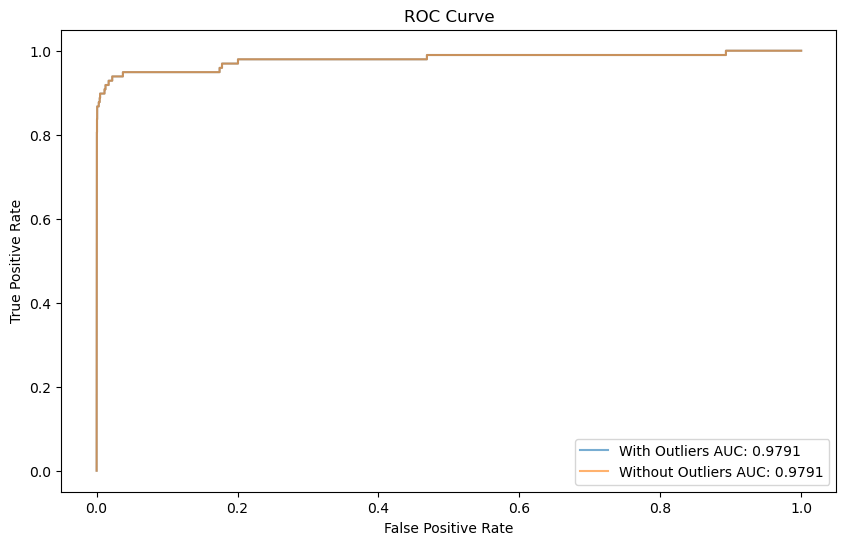

In [48]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# get probabilities for the positive class
logistic_4_preds = results_4_3['Logistic Regression'][0].predict_proba(xtest)[:, 1]
logistic_5_preds = results_5_3['Logistic Regression'][0].predict_proba(xtest)[:, 1]

# false positive rate and true positive rate
fpr1, tpr1, _ = roc_curve(ytest, logistic_4_preds, pos_label=1)
fpr2, tpr2, _ = roc_curve(ytest, logistic_5_preds, pos_label=1)

ax1.plot(fpr1, tpr1, label='With Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, logistic_4_preds)), alpha=0.6)
ax1.plot(fpr2, tpr2, label='Without Outliers AUC: {:.4f}'.format(roc_auc_score(ytest, logistic_5_preds)), alpha=0.6)

ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax1.legend()

plt.show()


The fact that the ROC curves and confusion matrices are identical suggests that removing outliers had little or no impact on the logistic regression models' ability to distinguish between fraudulent and non-fraudulent transactions. The outliers removed did not strongly influence classification, suggesting that outlier removal may not always lead to performance improvement. This may not always be the case however, it may just so happen for this test set or trained model that the results were identical.

### Conclusions
We determined that the data imbalance would be a challenge that needed to solved in order to achieve satisfactory training results. Through initial investigations from the data exploration and preperation, 5 sampling methods were proposed to see how models would train on each respective method and how the evaluation results on the test data would turn out. As a reminder, here are the 5 sampling methods:

1. No Balancing at All
2. Undersampling
3. Oversampling
4. Undersampling + Oversampling
5. Undersampling + Oversampling + Outlier Removal

Through model evaluation using confusion matrices and ROC curves, it was determined that the **logistic regression model** trained with **mixed sampling** (undersampling and oversampling) on **7192** training data points yielded the best results based on confusion matrices. 

It was also determined that while in theory removing outliers would yield better training results, there was a minimal to zero impact on the final logistic regression model.


### Further Work

Although the final recall of the logistic regression model was the highest, there were still 6 fraud cases that were not classified corrected by the model. In order to achieve models with even higher recall scores, more hyperparameter tuning using a more comprehensive grid search would allow the creation of the best version of the logistic regression model.

In theory, support vector machines are a better version of logistic regression models since they can also handle non-linear data with various kernals. Due to computational limitations, hyperparameter tuning for the SVM model was not as comprehensive as it could have been, and we were unable to train SVM models on the larger training datasets. Another possible model choice to further explore would be neural networks, but would require more computational resources and careful architecture choice since neural networks are highly customizable.

More work could also have been done on the data sampling to improve training data. Other oversampling methods such as ADASYN (Adaptive Synthetic Sampling) could have been used to focus on harder to learn datapoints. A more comprehensive outlier removal process might also allow for better model generalization and less overfitting.